In [124]:
# Standard packages
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Data Preparation
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# Models
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import xgboost as xgb

# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV

# Evaluation
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, f1_score, recall_score, precision_score, roc_curve, auc, roc_auc_score

# Data

In [125]:
op = pd.read_csv('order_products__train.csv')
opp = pd.read_csv('order_products__prior.csv')
aisles = pd.read_csv('aisles.csv')
departments = pd.read_csv('departments.csv')
orders = pd.read_csv('orders.csv')
products = pd.read_csv('products.csv')
tips_tr = pd.read_csv('tip_trainingsdaten.csv', index_col=0)
tips_te = pd.read_csv('tip_testdaten.csv', index_col=0)

c:\Users\jdhau\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Mithilfe eines Algorithmus werden die Datentypen der Tabellen optimimiert. Dies erhöht die Performance.

In [126]:
def reduce_mem_usage(train_data):
    start_mem = train_data.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in train_data.columns:
        col_type = train_data[col].dtype
        
        if col_type not in [object]:
            c_min = train_data[col].min()
            c_max = train_data[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    train_data[col] = train_data[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    train_data[col] = train_data[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    train_data[col] = train_data[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    train_data[col] = train_data[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    train_data[col] = train_data[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    train_data[col] = train_data[col].astype(np.float32)
                else:
                    train_data[col] = train_data[col].astype(np.float64)
        else:
            train_data[col] = train_data[col].astype('category')

    return train_data

orders = reduce_mem_usage(orders)
opp = reduce_mem_usage(opp)
aisles = reduce_mem_usage(aisles)
departments = reduce_mem_usage(departments)
products = reduce_mem_usage(products)

Memory usage of dataframe is 182.71 MB
Memory usage of dataframe is 989.82 MB
Memory usage of dataframe is 0.00 MB
Memory usage of dataframe is 0.00 MB
Memory usage of dataframe is 1.52 MB


Merge orders and tips

In [127]:
instacart_train = tips_tr.merge(orders)
instacart_train.head()

,order_id,tip,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,1,prior,1,2,8,NaN
1,2398795,1,1,prior,2,3,7,15.0
2,473747,1,1,prior,3,3,12,21.0
3,2254736,1,1,prior,4,4,7,29.0
4,431534,1,1,prior,5,4,15,28.0


In [128]:
instacart_train.eval_set.value_counts()

prior    3214874
test           0
train          0
Name: eval_set, dtype: int64

In [129]:
instacart_test = tips_te.merge(orders)
instacart_test.head()

,order_id,tip,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,1187899,NaN,1,train,11,4,8,14.0
1,1492625,NaN,2,train,15,1,11,30.0
2,2196797,NaN,5,train,5,0,11,6.0
3,525192,NaN,7,train,21,2,11,6.0
4,880375,NaN,8,train,4,1,14,10.0


Merge opp, aisles and departments

In [130]:
opp_reduced = opp.groupby('order_id').head(1)

In [131]:
products_departments = products.drop(columns=['product_name', 'aisle_id']).set_index('product_id').to_dict()['department_id']
opp['departments_id'] = opp['product_id'].map(products_departments, na_action='ignore')

products_aisles = products.drop(columns=['product_name', 'department_id']).set_index('product_id').to_dict()['aisle_id']
opp['aisles_id'] = opp['product_id'].map(products_aisles, na_action='ignore')

In [132]:
opp['value'] = 1
opp_aisles = opp.pivot_table(index=['order_id'], columns=['aisles_id'], values='value', margins=False, aggfunc='sum').add_prefix('aisles_')

opp_aisles = opp_aisles.fillna(0)
opp_aisles = reduce_mem_usage(opp_aisles)

opp_reduced = opp_reduced.merge(opp_aisles, left_on='order_id', right_index=True, suffixes=('', 'aisles_'))

Memory usage of dataframe is 3311.22 MB


In [133]:
opp['value'] = 1
opp_departments = opp.pivot_table(index=['order_id'], columns=['departments_id'], values='value', margins=False, aggfunc='sum').add_prefix('departments_')

opp_departments = opp_departments.fillna(0)
opp_departments = reduce_mem_usage(opp_departments)

opp_reduced = opp_reduced.merge(opp_departments, left_on='order_id', right_index=True, suffixes=('', 'departments_'))

Memory usage of dataframe is 539.61 MB


In [134]:
opp_reduced

,order_id,product_id,add_to_cart_order,reordered,aisles_1,aisles_2,aisles_3,aisles_4,aisles_5,aisles_6,...,departments_12,departments_13,departments_14,departments_15,departments_16,departments_17,departments_18,departments_19,departments_20,departments_21
0,2,33120,1,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,5.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
9,3,33754,1,1,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
17,4,46842,1,0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0
30,5,13176,1,1,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,2.0,0.0,0.0,3.0,3.0,0.0,4.0,1.0,0.0
56,6,40462,1,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32434455,3421079,30136,1,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32434456,3421080,27845,1,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0
32434465,3421081,38185,1,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0
32434472,3421082,17279,1,1,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0


In [135]:
instacart_train = instacart_train.merge(opp_reduced.drop(columns=['add_to_cart_order', 'reordered', 'product_id']), left_on='order_id', right_on='order_id')

In [136]:
instacart_train.isnull().sum().head(20)

order_id                       0
tip                            0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
aisles_1                       0
aisles_2                       0
aisles_3                       0
aisles_4                       0
aisles_5                       0
aisles_6                       0
aisles_7                       0
aisles_8                       0
aisles_9                       0
aisles_10                      0
aisles_11                      0
aisles_12                      0
dtype: int64

# Business Understanding

In der Aufgaben geht es um einen Lieferdienst namens Instacart, bei dem Kunden Bestellungen aufgeben
können. Instacart schickt dann Fahrer los , die die Ware in
Supermärkten abholen und zum Kunden bringen. 
<br>
Dieser Datensatz enthält eine zusätzliche Spalte „Tip“, die zu den einzelnen
Bestellungen angibt, ob der Kunden beim Erhalt der Ware ein Trinkgeld gegeben hat oder nicht. Kern
der Aufgabe ist vorherzusagen, bei welchen Bestellungen Trinkgeld gegeben werden wird und bei
welchen nicht. 

### 1. Tip-Prediction
Es soll vorhergesagt werden, bei welchen Bestellungen die Kunden dem Fahrer Trinkgeld
gegeben werden und bei welchen nicht. Die Vorhersage kann dabei auf allen Informationen
basieren, die unmittelbar nach Aufgeben der Bestellung zur Verfügung stehen, d.h. alle
Daten zur aktuellen Bestellung sowie die gesamte Vorgeschichte. 
Zielerwartung sind mindestens 70% Genauigkeit bei der Vorhersage, ob ein Tip erfolgen wird oder nicht.

### 2. Analyse der Tip-Einflussfaktoren
Zusätzlich sollen auch interpretierbare Erkenntnisse geliefert werden, wovon es abhängt, ob
Trinkgeld gegeben wird. Diese sollen nachvollziehbar dargestellt werden. 

# Data Understanding

## Beschreibung der Daten

Der Instacart Datensatz besteht aus über 3.2 Millionen Bestellungen. Er ist aufgeteilt in die Datentabellen: 
- orders: Information über die Bestellungen
- opp: Information über die in den Bestellungen enthaltenen Produkte
- tips: Information ob ein tip gegeben wurde, oder nicht
- products: Information zu den bestellbaren Produkten
- aisles: Information zu den Inseln, in welchen die Produkte angeboten werden
- departements: Information zu den Abteilungen, in welchen die Produkte angeboten werden

Im ersten Schritt wurden orders und tips verbunden. Über eine Aggregation wurden zudem die Information zu den Aisles und Departements der in einer Bestellung enthaltenen Produkte integriert.
Die Daten pro Bestellung sind vollständig, bis auf den Wochentag der Bestellung (order_dow), bei dem Werte mit nan angegeben sind, welche später behandelt werden werden. Alle Daten sind ganzzahlige Werte (int), außer days_since_prior_order, welches ein Kommazahlenwert (float) ist. Eine weitere Ausnahme ist das Objekt eval_set.
Für die Optmierung der Datentypen wurden die Speicherbereiche für die int- und float-Werte jeweils minimal gewählt.

Im folgenden werden die bestehenden Features sowie die im Rahmen des Features Engineering-Prozesses kreiirten Featuers beschrieben.

In [137]:
instacart_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214874 entries, 0 to 3214873
Columns: 163 entries, order_id to departments_21
dtypes: category(1), float16(156), int32(1), int64(2), int8(3)
memory usage: 1.0 GB


### order_id (int)
- Numerisches Features, welches für jede Bestellung eine einzigartige ID enthält. Insgesamt gibt es 3.214.874 Millionen distinkte Bestellungen.

In [138]:
instacart_train['order_id'].nunique()

3214874

### user_id (int)
- Numerisches Feature, welches für jeden distinkten Nutzer eine einzigeartige ID enthält. Die Bestellungen wurden von 206209 distinkten Nutzern getätigt.

In [139]:
instacart_train['user_id'].nunique()

206209

### tip (int)
- Binäres Features mit der Information, ob ein Tip gebeben wurde. 0 bedeutet, dass kein Tip gegeben wurde, 1 bedeutet, dass ein Tip gegeben wurde. 
- Bei circa 1.9 Millionen Bestellungen wurde Trinkgeld gegeben, bei 1.4 Millionen nicht. 

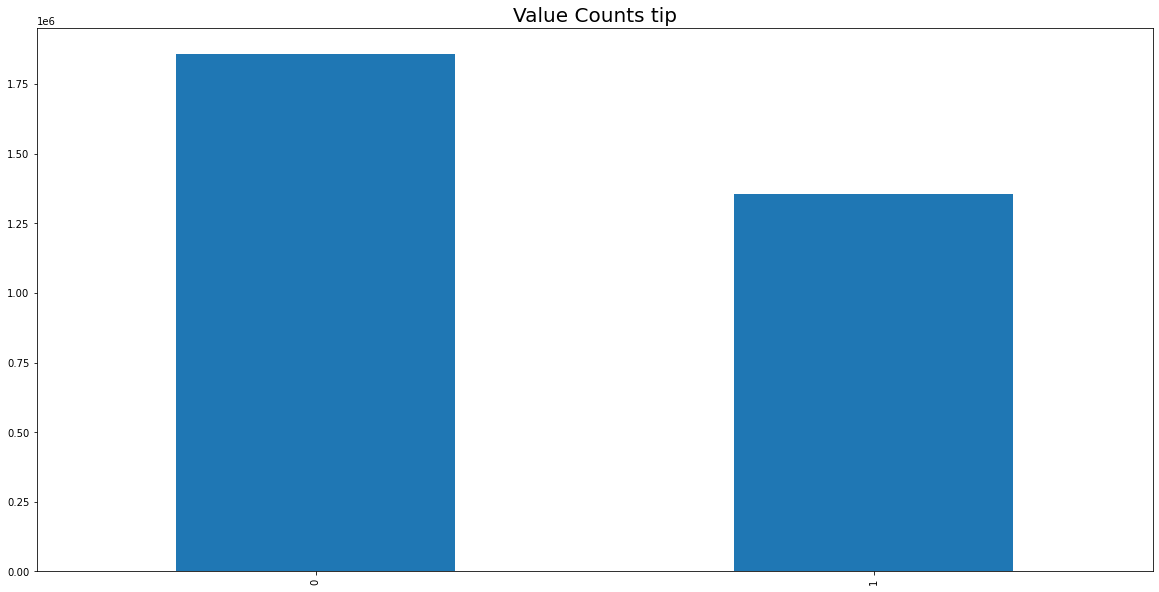

In [143]:
plt.figure(figsize=(20, 10))
ax = instacart_train['tip'].value_counts().sort_index().plot(kind='bar')
ax.set_title(label = 'Value Counts tip', fontsize = 20)
plt.show()

### eval_set
- Kategorisches Features mit der Information zu welchem Set die Beobachtung gehört. Verfügbare Werte sind: train und test. Train kann für das Training benutzt werden. Für Test-Beobachtungen soll eine Vorhersage generiert werden. Das Feature ist daher im Trainingsset stetig und enthält keine weitere Information.

In [141]:
instacart_train['eval_set'].nunique()

1

### order_number
- Numerisches Features mit der Information, die wievielte Bestellung die des jeweiligen Nutzers die Beobachtung ist.
- Jede Person hat mindestens 3 Mal und maximal 99 Mal bestellt. Durchschnittlich hat jede Person ca. 17 Bestellungen aufgegeben. 

In [142]:
instacart_train['order_number'].mean()

17.191065652961825

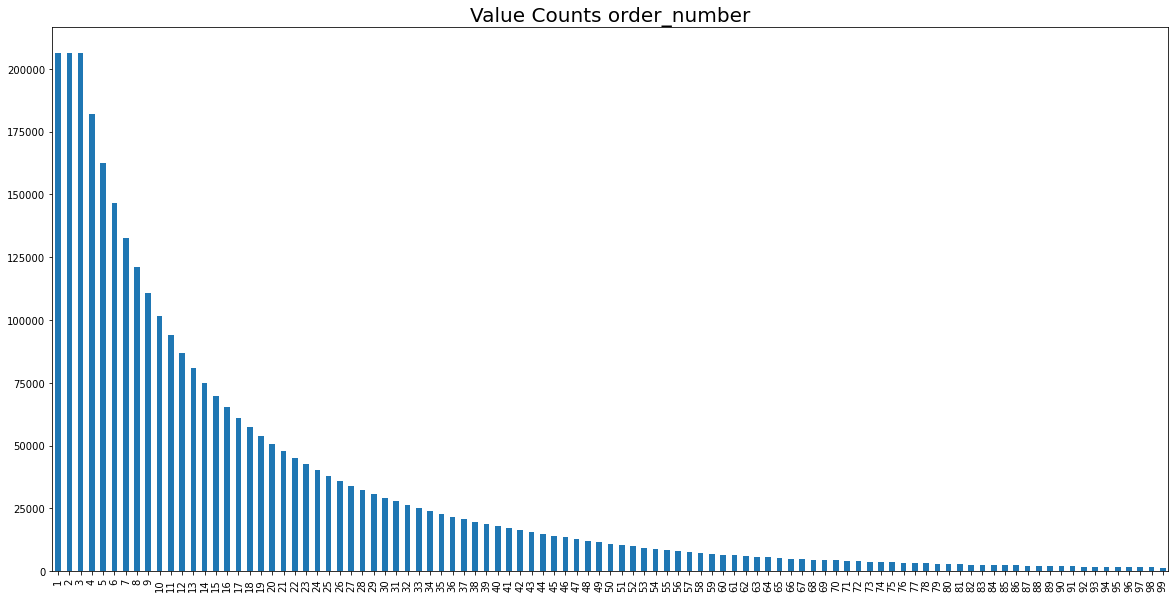

In [144]:
plt.figure(figsize=(20, 10))
ax = instacart_train['order_number'].value_counts().sort_index().plot(kind='bar')
ax.set_title(label = 'Value Counts order_number', fontsize = 20)
plt.show()

### order_dow
- Numerisches Features mit der Information über den Wochentag der Bestellung. Die Information ist als Zahl zwischen 0 und 6 encodiert. Es wird angenommen, dass die Tage 0 und 1 mit mehr Bestellungen die Tage Samstag und Sonntag sind. Die weiteren Tage sind in der üblichen Reihenfolge.
- Die meisten Bestellungen erfolgen am Wochenende.

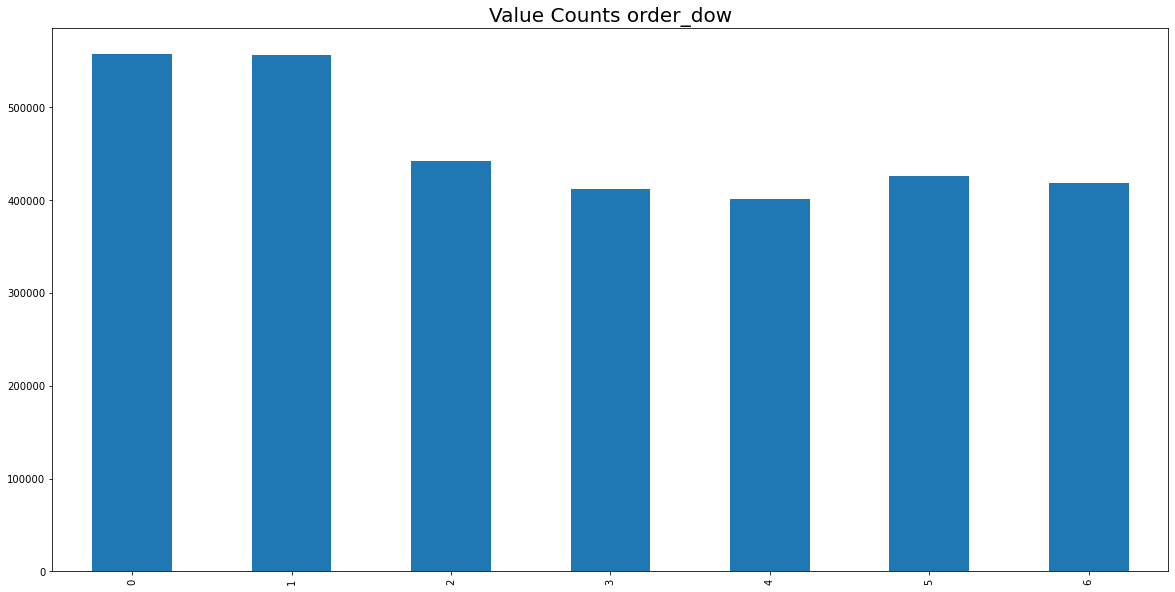

In [145]:
plt.figure(figsize=(20, 10))
ax = instacart_train['order_dow'].value_counts().sort_index().plot(kind='bar')
ax.set_title(label = 'Value Counts order_dow', fontsize = 20)
plt.show()

### order_hour_of_day
- Numerisches Features mit der Information über die Uhrzeit der Bestellung.
- Die wenigsten Bestellungen gehen rund um 3 Uhr nachts ein, die meisten um 10 Uhr vormittags. 

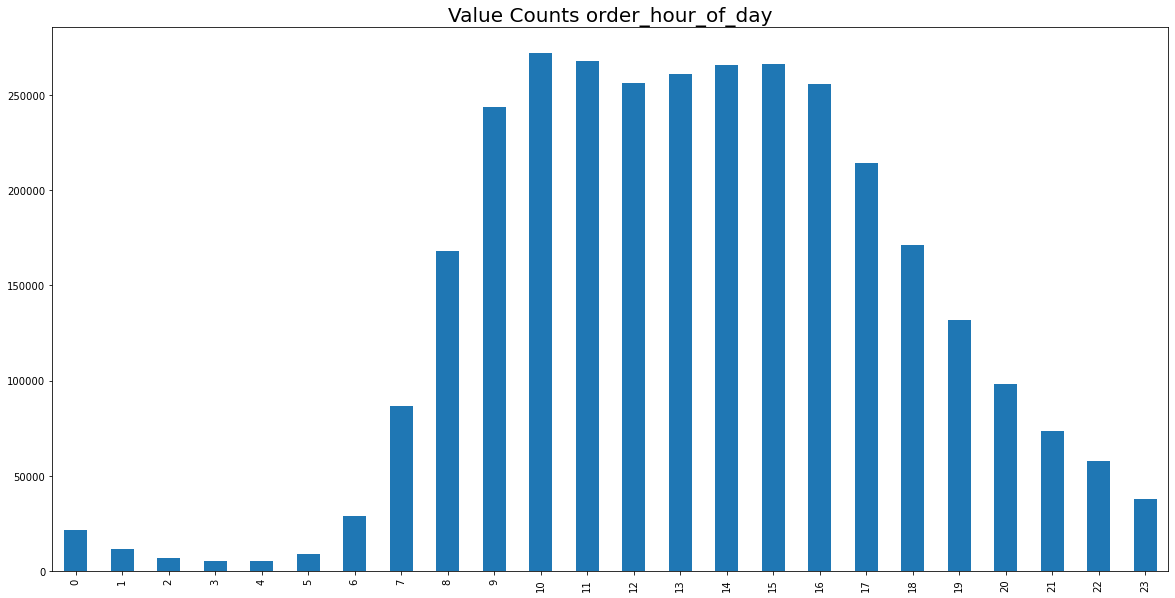

In [146]:
plt.figure(figsize=(20, 10))
ax = instacart_train['order_hour_of_day'].value_counts().sort_index().plot(kind='bar')
ax.set_title(label = 'Value Counts order_hour_of_day', fontsize = 20)
plt.show()

### days_since_prior_order
- Numerisches Feature mit der Information über die Anzahl der vergangengen Tage seit der letzten seit der letzten Bestellung.
- Es vergehen zwischen keinem und mehr als 30 Tage, bis die Personen erneut bestellen. Der Durchschnitt des Features ist alle 10,7 Tage.

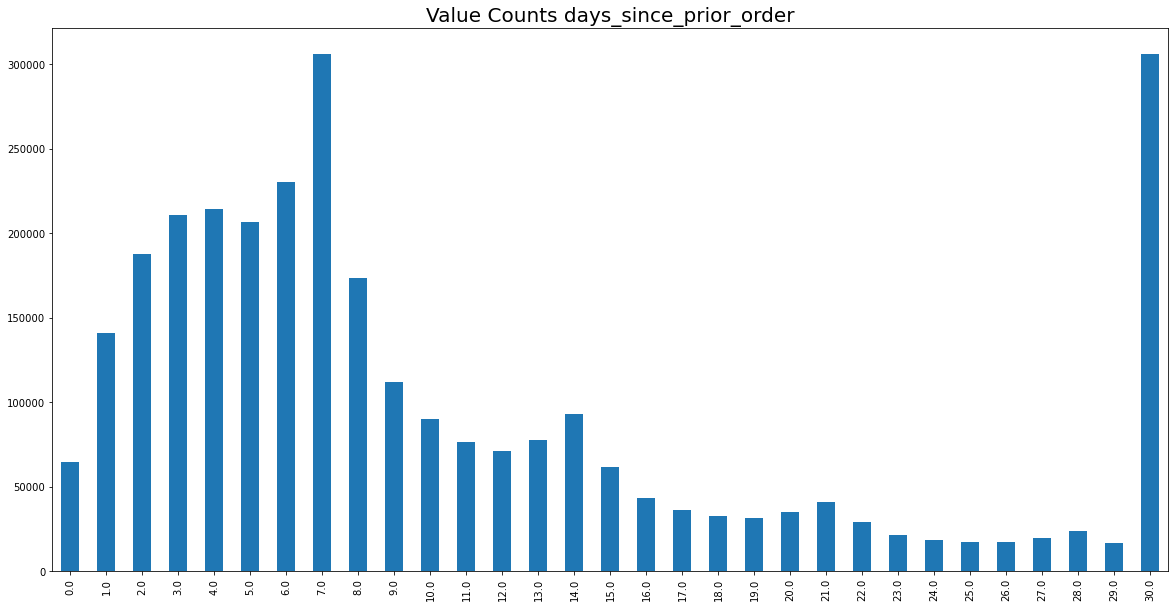

In [148]:
plt.figure(figsize=(20, 10))
ax = instacart_train['days_since_prior_order'].value_counts().sort_index().plot(kind='bar')
ax.set_title(label = 'Value Counts days_since_prior_order', fontsize = 20)
plt.show()

### amount_ordered_products
- Numerisches Features mit der Information über die Anzahl der Prdukte, welche in der Bestellung enthalten waren. Der Wert ergibt sich aus dem Count-Aggreget über die Order ID auf der Order Products Tabelle.
- Am häufigsten werden 10 Produkte gleichzeitig bestellt.

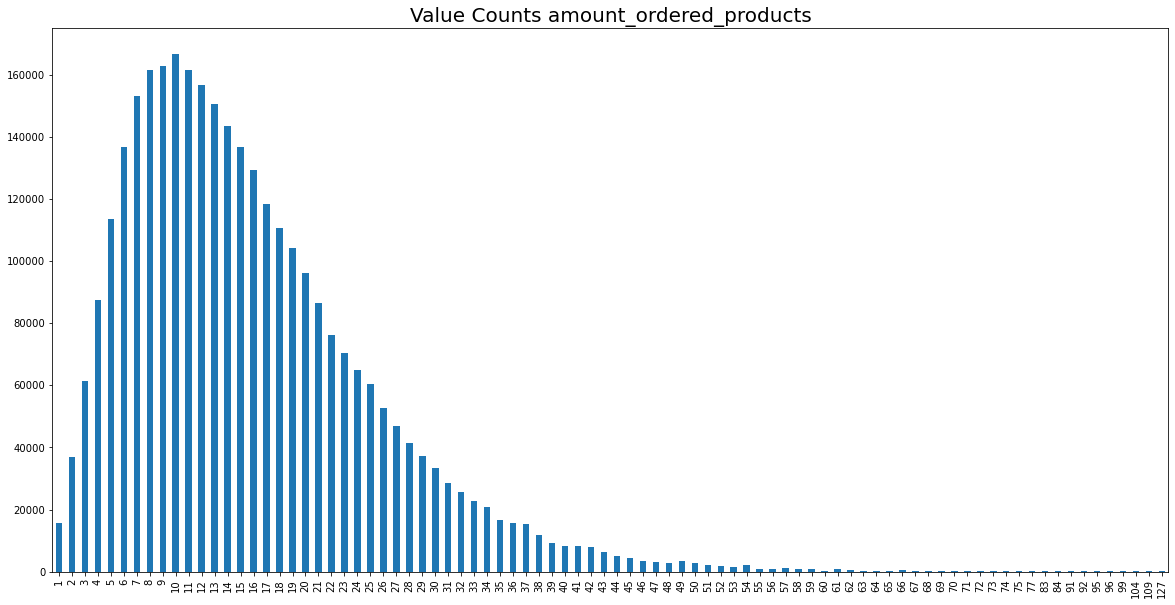

In [152]:
# Get amount of products in order
instacart_train['amount_ordered_products'] = opp.groupby('order_id')['product_id'].transform('count')
instacart_train['amount_ordered_products'] = instacart_train['amount_ordered_products'].astype('int16')

plt.figure(figsize=(20, 10))
ax = instacart_train['amount_ordered_products'].value_counts().sort_index().plot(kind='bar')
ax.set_title(label = 'Value Counts amount_ordered_products', fontsize = 20)
plt.show()

### amount_reordered_products
- Numerisches Features mit der Information über die Anzahl der wiederbestellten Produkte, welche in der Bestellung enthalten waren. Der Wert ergibt sich aus dem Summen-Aggreget über die reordered-Information auf der Order Products Tabelle.

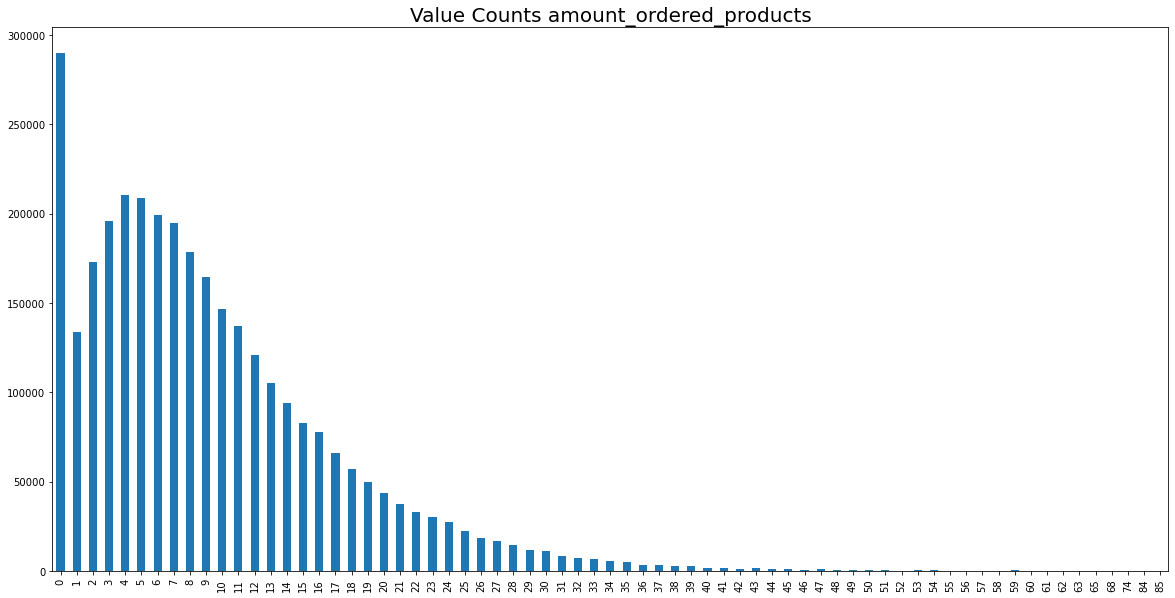

In [156]:
instacart_train['amount_reordered_products'] = opp.groupby('order_id')['reordered'].transform('sum')
instacart_train['amount_reordered_products'] = instacart_train['amount_reordered_products'].astype('int16')

plt.figure(figsize=(20, 10))
ax = instacart_train['amount_reordered_products'].value_counts().sort_index().plot(kind='bar')
ax.set_title(label = 'Value Counts amount_ordered_products', fontsize = 20)
plt.show()

### factor_reorderer_products
- Numerisches Features mit der Information über Anteil der wiederbestellen Produkte in einer Bestellung. Der Wert ergibt sich aus dem Verhältnis der zuvor erstellen Features.

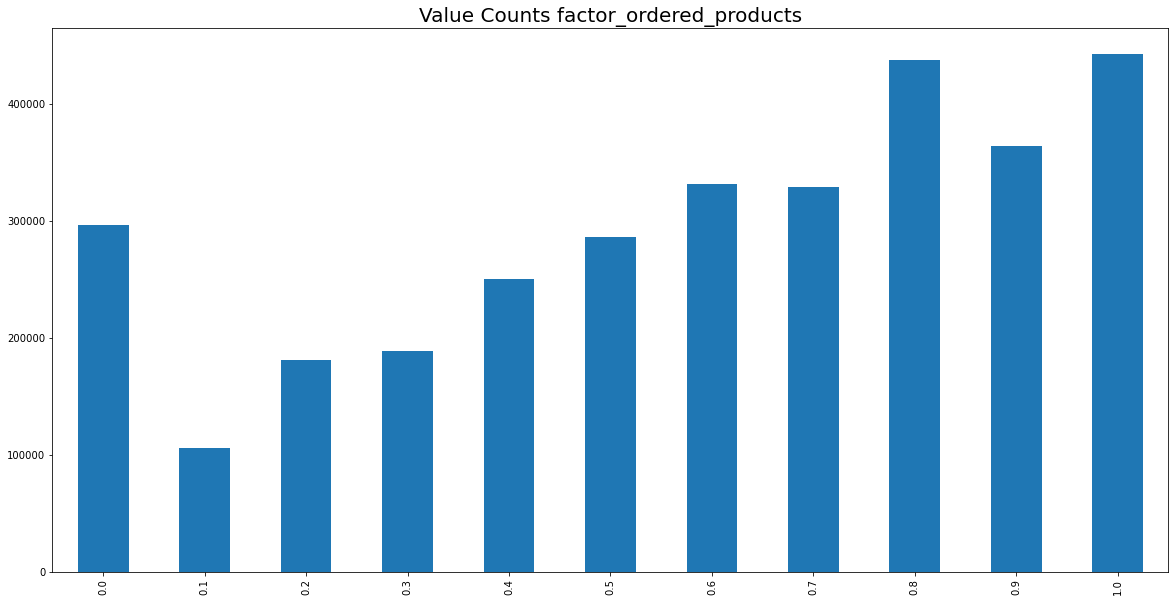

In [154]:
instacart_train['factor_reordered_products'] = instacart_train['amount_reordered_products'] / instacart_train['amount_ordered_products']
instacart_train['factor_reordered_products'] = instacart_train['factor_reordered_products'].round(1)

plt.figure(figsize=(20, 10))
ax = instacart_train['factor_reordered_products'].value_counts().sort_index().plot(kind='bar')
ax.set_title(label = 'Value Counts factor_ordered_products', fontsize = 20)
plt.show()

### aisles_X

### departments_X

Beschreibung des products Datensatzes:

Es sind fast 50.000 Produkte vorhanden, welche über 4 Spalten beschrieben werden. Der Datensatz ist vollständig, es gibt keine Null-Werte. 

In [27]:
products.shape

(49688, 4)

In [28]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49688 entries, 0 to 49687
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   product_id     49688 non-null  int32   
 1   product_name   49688 non-null  category
 2   aisle_id       49688 non-null  int16   
 3   department_id  49688 non-null  int8    
dtypes: category(1), int16(1), int32(1), int8(1)
memory usage: 1.9 MB


Beschreibung des departments Datensatzes

Es gibt 21 Abteilungen / Kategorien, in welche jedes Proukt eingeordnet wird. Der Datensatz besteht aus zwei Spalten. 

In [29]:
departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [30]:
departments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   department_id  21 non-null     int8    
 1   department     21 non-null     category
dtypes: category(1), int8(1)
memory usage: 894.0 bytes


In [31]:
departments.describe()

,department_id
count,21.000000
mean,11.000000
std,6.204837
min,1.000000
25%,6.000000
50%,11.000000
75%,16.000000
max,21.000000


Beschreibung des aisles Datensatzes

Im Datensatz sind 134 Supermarktgänge gelistet, welche durch eine schriftliche Beschreibung genau aussagen, was in diesem Gang zu finden ist. 

In [155]:
print(aisles.info())
aisles.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   aisle_id  134 non-null    int16   
 1   aisle     134 non-null    category
dtypes: category(1), int16(1)
memory usage: 5.8 KB
None


,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


## Daten verstehen

In [35]:
instacart_train.describe()

,order_id,tip,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,amount_ordered_products,amount_reordered_products,aisles_1,...,departments_13,departments_14,departments_15,departments_16,departments_17,departments_18,departments_19,departments_20,departments_21,factor_reordered_products
count,3.214874e+06,3.214874e+06,3.214874e+06,3.214874e+06,3.214874e+06,3.214874e+06,3008665.0,3.214874e+06,3.214874e+06,3214874.0,...,3214874.0,3214874.0,3214874.0,3214874.0,3214874.0,3214874.0,3214874.0,3214874.0,3214874.0,3.214874e+06
mean,1.710827e+06,4.217627e-01,1.029701e+05,1.719107e+01,2.776364e+00,1.344347e+01,NaN,1.008888e+01,5.949389e+00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.995255e-01
std,9.875206e+05,4.938411e-01,5.953411e+04,1.779950e+01,2.041806e+00,4.226246e+00,0.0,7.525398e+00,5.842059e+00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.408452e-01
min,2.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.0,1.000000e+00,0.000000e+00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00
25%,8.556832e+05,0.000000e+00,5.138500e+04,5.000000e+00,1.000000e+00,1.000000e+01,4.0,5.000000e+00,2.000000e+00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.000000e-01
50%,1.711120e+06,0.000000e+00,1.026620e+05,1.100000e+01,3.000000e+00,1.300000e+01,7.0,8.000000e+00,4.000000e+00,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,7.000000e-01
75%,2.566034e+06,1.000000e+00,1.543720e+05,2.400000e+01,5.000000e+00,1.600000e+01,15.0,1.400000e+01,8.000000e+00,0.0,...,1.0,0.0,0.0,3.0,0.0,0.0,1.0,0.0,0.0,9.000000e-01
max,3.421083e+06,1.000000e+00,2.062090e+05,9.900000e+01,6.000000e+00,2.300000e+01,30.0,1.450000e+02,1.300000e+02,10.0,...,41.0,43.0,23.0,48.0,48.0,60.0,76.0,16.0,9.0,1.000000e+00


- Weitere Fragestellungen
    - DOW zu Tip
    - Uhrzeit zu Tip
    - Days since prior order zu Tip
    - Order Number zu Tip
    - Departments zu Tip
    - Aisles zu Tip
    - Anzahl Produkte in der Bestellung zu Tip
    - Top Nutzer nach Tip, Neg Nutzer nach Tip
    - Products zu Tip (Top 20?, Neg 20?)

### User zu tip
- Je höher die durchschnittliche tip-Wahrscheinlichkeit des Nutzers ist, dest höher ist die Wahrscheinlichkeit, dass er auch bei der vorliegenden Bestellung einen tip geben hat.
- Auch bei der Betrachtung der (1 bzw. 3) direkt zuvor erfolgen Bestellung. ist eine Korrelation der vorherigen tips mit der tip-Wahrscheinlichkeit für die vorliegende Bestellung wahrscheinlich. 

In [36]:
# Order the dataframe by user_id and order_number
instacart_train = instacart_train.sort_values(['user_id', 'order_number'], ascending = [True, True])

# Shift the value previous tips per user and fill Nans with 0s
instacart_train['previous_order_tip'] = instacart_train.groupby('user_id')['tip'].shift(1)
instacart_train['previous_order_tip']= instacart_train['previous_order_tip'].fillna(0)
instacart_train['2_previous_order_tip'] = instacart_train.groupby('user_id')['tip'].shift(2)
instacart_train['2_previous_order_tip']= instacart_train['2_previous_order_tip'].fillna(0)
instacart_train['3_previous_order_tip'] = instacart_train.groupby('user_id')['tip'].shift(3)
instacart_train['3_previous_order_tip']= instacart_train['3_previous_order_tip'].fillna(0)
instacart_train['3_previous_tip_user'] = (instacart_train['previous_order_tip'] + instacart_train['2_previous_order_tip'] + instacart_train['3_previous_order_tip']) / 3
instacart_train['3_previous_tip_user'].round(1)
instacart_train = instacart_train.drop(columns=['3_previous_order_tip', '2_previous_order_tip'])

# Get the mean tip value per user
instacart_train['mean_tip_user'] = instacart_train.groupby('user_id')['tip'].transform('mean')
instacart_train['mean_tip_user'] = instacart_train['mean_tip_user'].round(1)

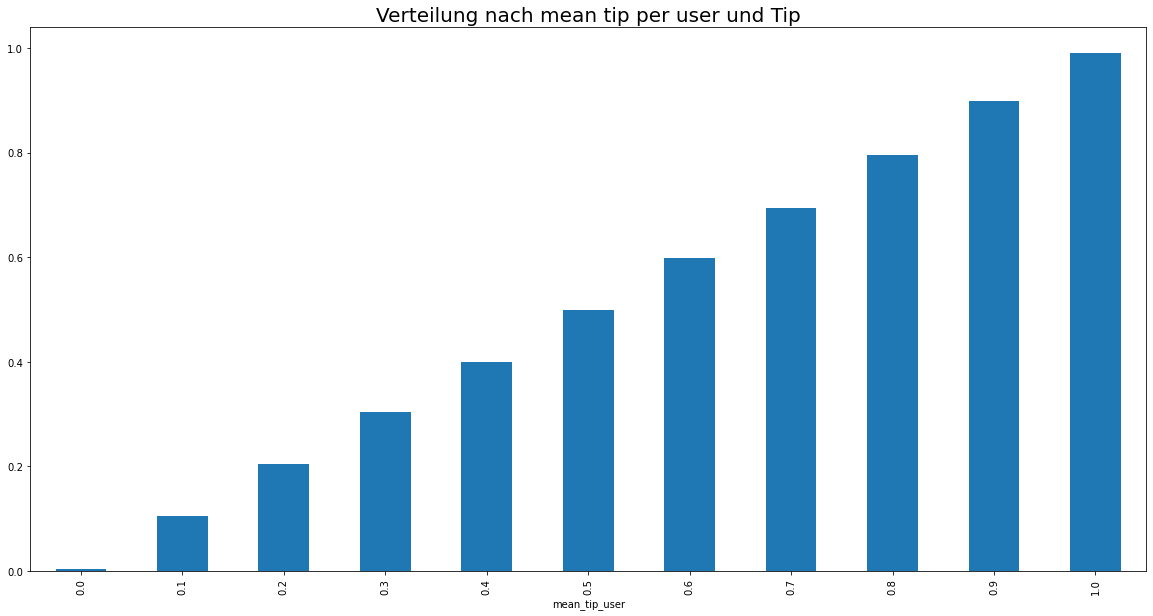

In [37]:
plt.figure(figsize=(20, 10))
ax = instacart_train.groupby('mean_tip_user').tip.mean().plot(kind='bar')
ax.set_title(label = 'Verteilung nach mean tip per user und Tip', fontsize = 20)
plt.show()

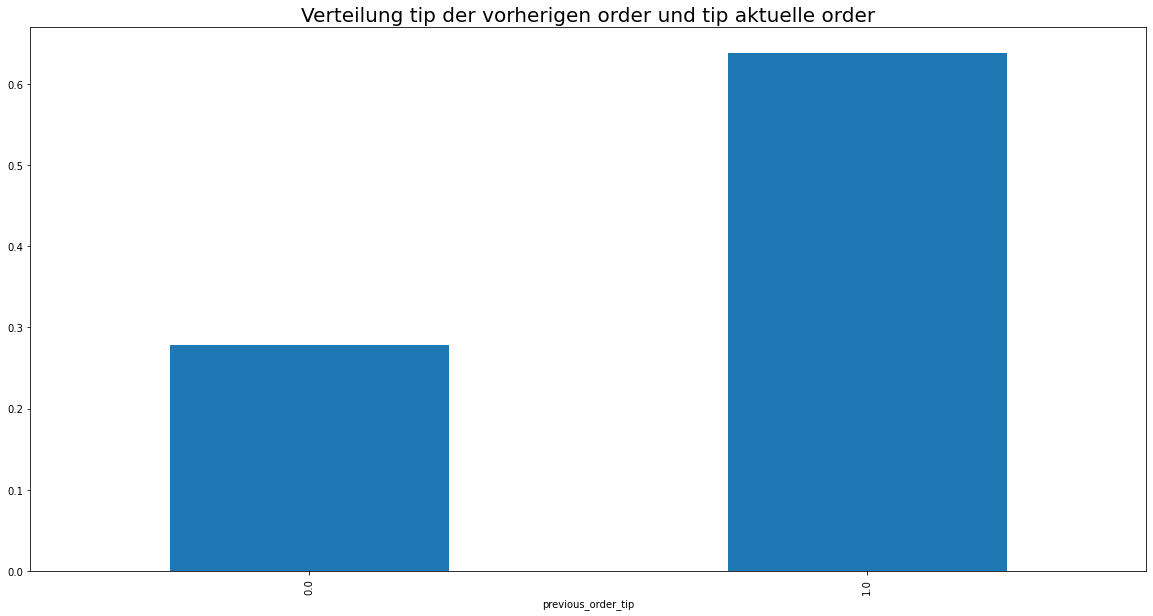

In [38]:
plt.figure(figsize=(20, 10))
ax = instacart_train.groupby('previous_order_tip').tip.mean().plot(kind='bar')
ax.set_title(label = 'Verteilung tip der vorherigen order und tip aktuelle order', fontsize = 20)
plt.show()

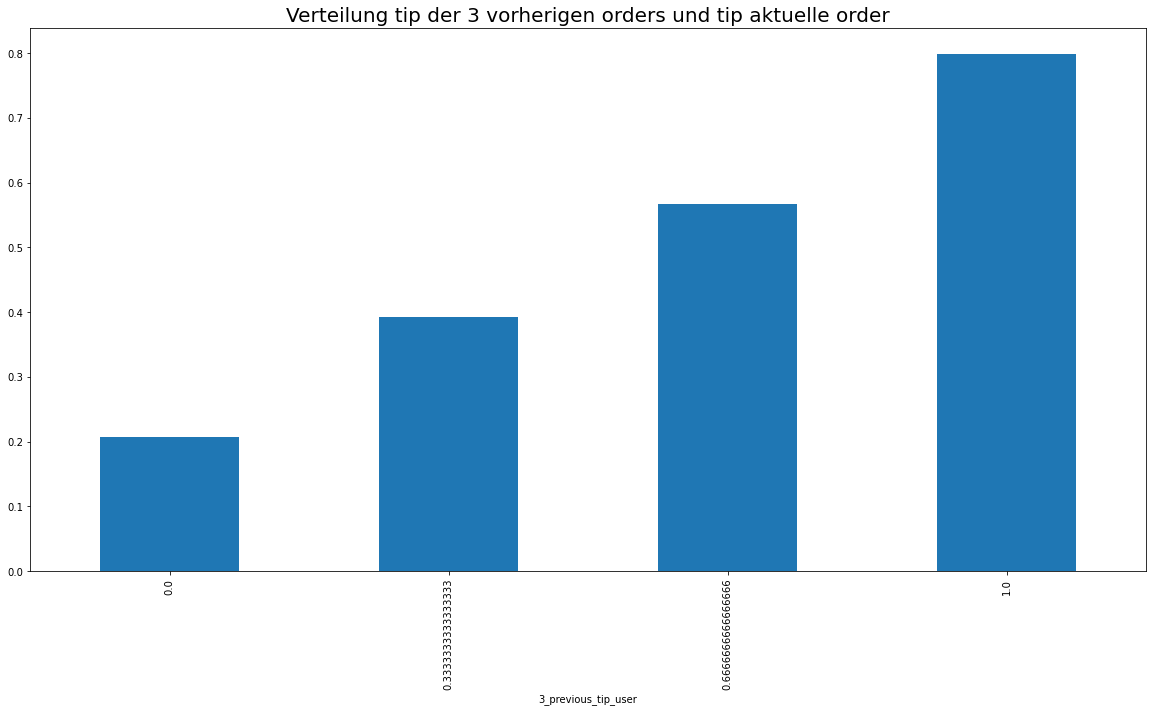

In [39]:
plt.figure(figsize=(20, 10))
ax = instacart_train.groupby('3_previous_tip_user').tip.mean().plot(kind='bar')
ax.set_title(label = 'Verteilung tip der 3 vorherigen orders und tip aktuelle order', fontsize = 20)
plt.show()

### Day of week zu tip
- Samstag und Sonntag ist die Wahrscheinlichkeit, dass ein tip gegeben wird, um ca. 0,1 höher. Der Unterschied ist statistisch signifikant, da für alle Ausprägungen ausreichend Beobachtungen vorliegen.

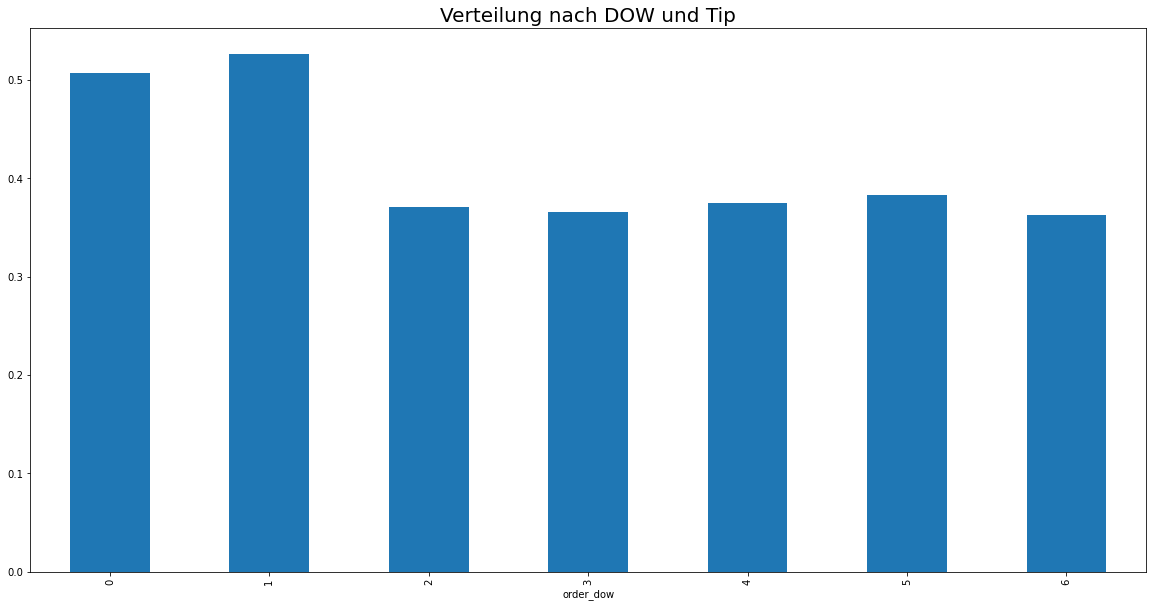

In [40]:
plt.figure(figsize=(20, 10))
ax = instacart_train.groupby('order_dow').tip.mean().plot(kind='bar')
ax.set_title(label = 'Verteilung nach DOW und Tip', fontsize = 20)
plt.show()

### Hour of day zu tip
- Zwischen 19 Uhr und 4 Uhr scheint die Wahrscheinlichkeit, dass ein tip gegegeben wird, um ca. 0,1 höher. Ca. 14% der Bestellungen fallen in diesen Zeitraum. Somit scheint der Unterschied auch statistisch signifikant zu sein.

Ca. 13.955476948707787% der Bestellungen wurden in zwischen 19 und 4 Uhr aufgegeben.


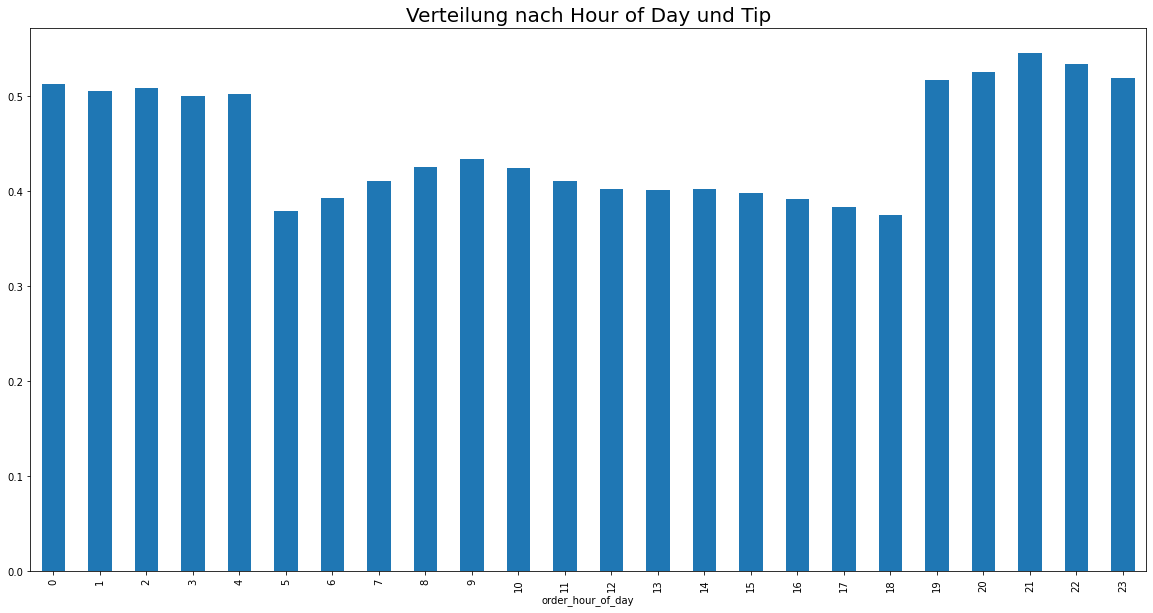

In [41]:
night_percentage = len(instacart_train[(instacart_train['order_hour_of_day'] < 5) | (instacart_train['order_hour_of_day'] > 18)]) / len(instacart_train)
print(f'Ca. {night_percentage*100}% der Bestellungen wurden in zwischen 19 und 4 Uhr aufgegeben.')
plt.figure(figsize=(20, 10))
ax = instacart_train.groupby('order_hour_of_day').tip.mean().plot(kind='bar')
ax.set_title(label = 'Verteilung nach Hour of Day und Tip', fontsize = 20)
plt.show()

### Days since prior order zu tip

- Aufwärtstrend in der ersten Woche an den Tagen 1-7 erkennbar.
- Erste Trendkomponente: Statistisch signifikanter Abwärtstrend hinsichtlich der tip-Wahrscheinlichkeit ab Beginn der zweiten Woche. (Siehe Abbildung Verteilung nach Weeks since prior order und tip)
- Zweite Trendkomponente: Statistisch signifkant höherer tip-Wahrscheinlichkeit, wenn relativ gesehen wieder an denselben Wochentagen bestellt wird (Erste Bestellung Dienstags, zweite Bestellung Dienstags). Dagegen deutlich geringere tip-Wahrscheinlichkeit, wenn zwei Wochentage später die nächste Bestellung erfolgt (Erste Bestellung Dienstags, zweite Bestellung Donnerstags) (Siehe Abbildung Verteilung nach relative day since prior order und tip)

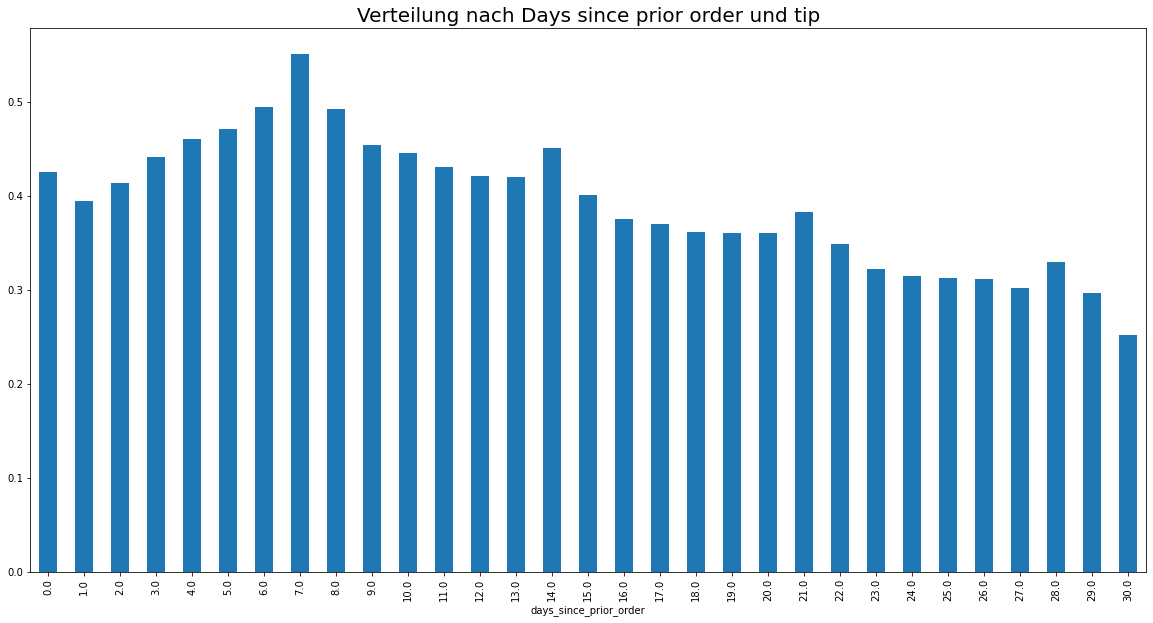

In [42]:
plt.figure(figsize=(20, 10))
ax = instacart_train.groupby('days_since_prior_order').tip.mean().plot(kind='bar')
ax.set_title(label = 'Verteilung nach Days since prior order und tip', fontsize = 20)
plt.show()

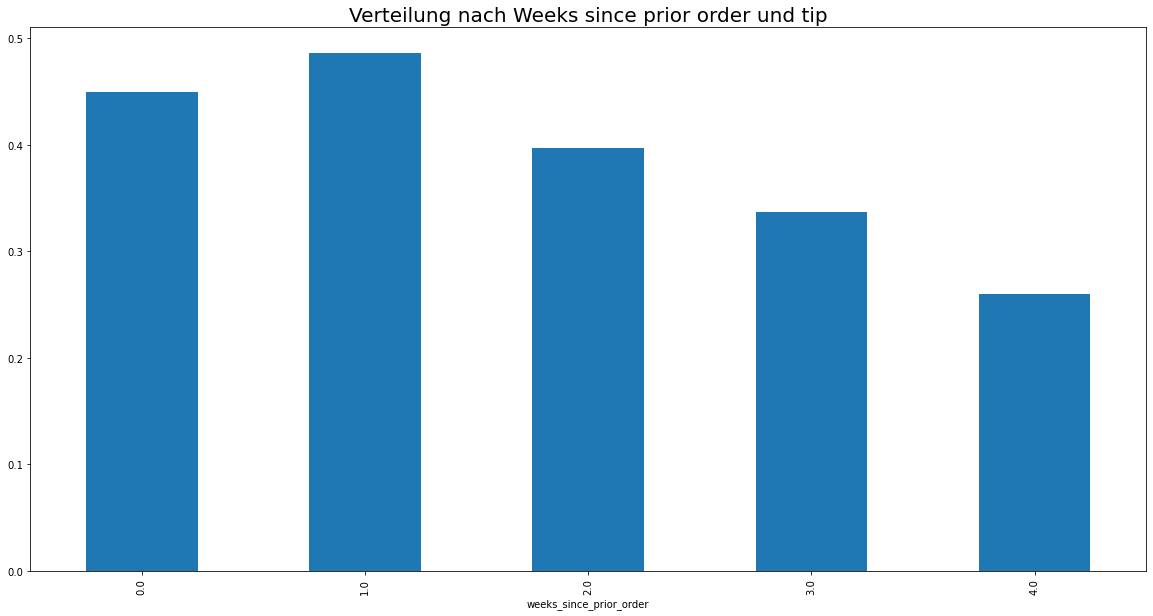

In [43]:
plt.figure(figsize=(20, 10))
instacart_train['weeks_since_prior_order'] = instacart_train['days_since_prior_order'] // 7
ax = instacart_train.groupby('weeks_since_prior_order').tip.mean().plot(kind='bar')
ax.set_title(label = 'Verteilung nach Weeks since prior order und tip', fontsize = 20)
plt.show()

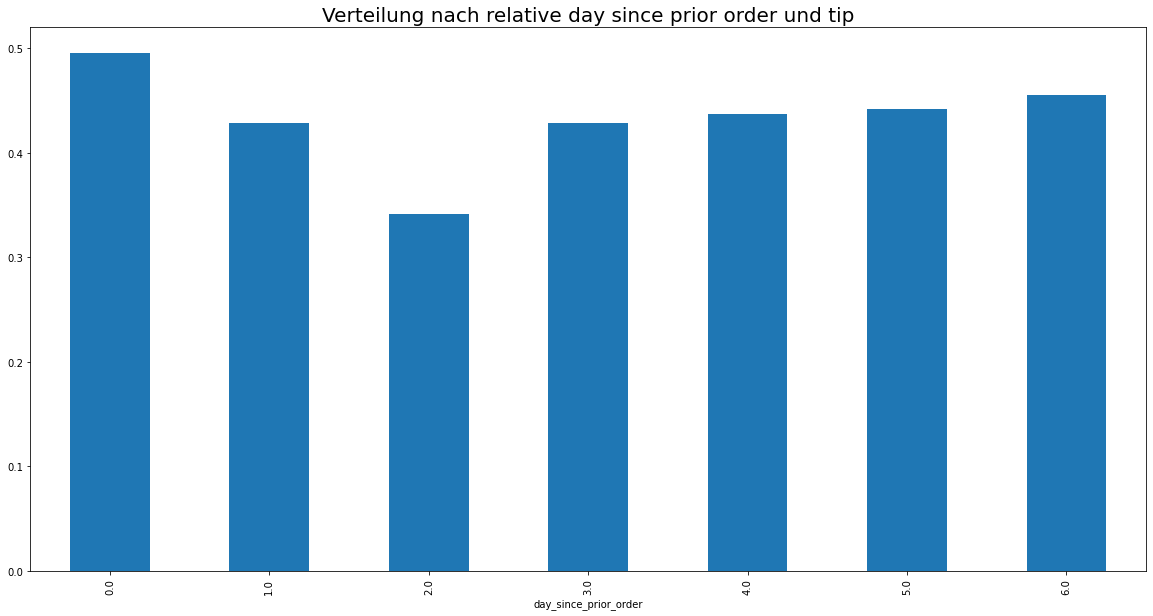

In [44]:
plt.figure(figsize=(20, 10))
instacart_train['day_since_prior_order'] = instacart_train['days_since_prior_order'] % 7
ax = instacart_train.groupby('day_since_prior_order').tip.mean().plot(kind='bar')
ax.set_title(label = 'Verteilung nach relative day since prior order und tip', fontsize = 20)
plt.show()

### Mean days since prior order per User zu tip
- Nutzer, die im Durschnitt nach 0 bis 7 Tagen erneut bestellen haben eine stark steigende tip-Wahrscheinlichkeit.
- Die höchste tip-Wahrscheinlichkeit haben Nutzer, die durchschnittlichen nach genau 7 Tagen erneut bestellen.
- Nutzer, die im Durchscnitt mehr nach mehr als 7 Tagen erneut bestellen, haben eine sinkende tip-Wahrscheinlichkeit.

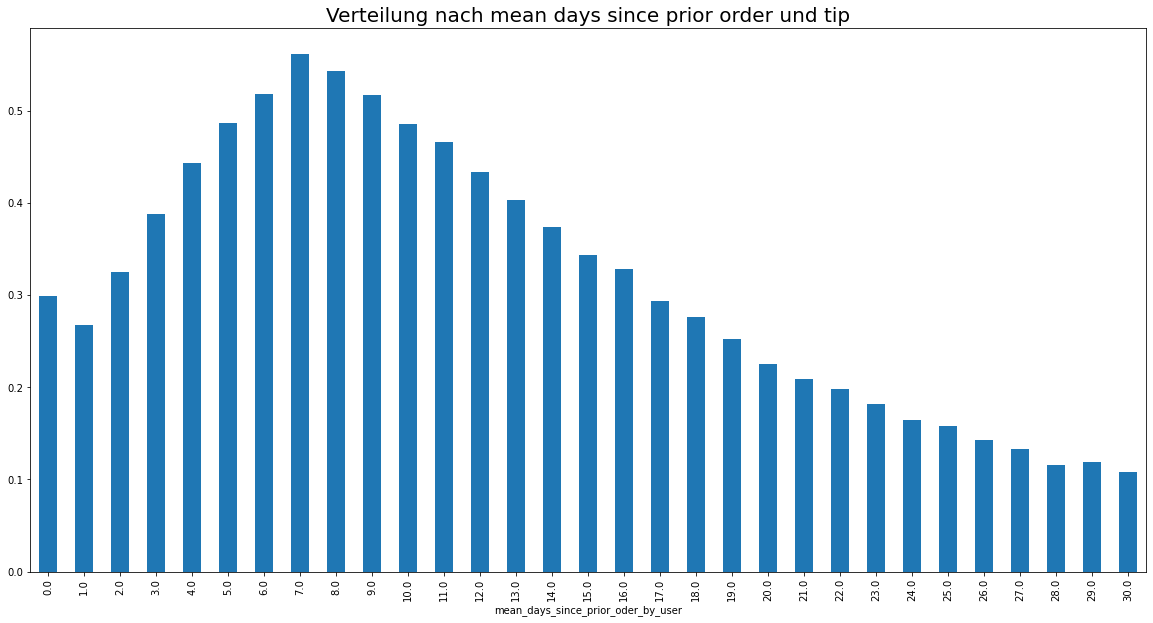

In [45]:
plt.figure(figsize=(20, 10))
instacart_train['mean_days_since_prior_oder_by_user'] = instacart_train.groupby('user_id')['days_since_prior_order'].transform('mean')
instacart_train['mean_days_since_prior_oder_by_user'] = instacart_train['mean_days_since_prior_oder_by_user'].round(0)
ax = instacart_train.groupby('mean_days_since_prior_oder_by_user').tip.mean().plot(kind='bar')
ax.set_title(label = 'Verteilung nach mean days since prior order und tip', fontsize = 20)
plt.show()

### Order number zu tip
- Mit der Anzahl der Bestellungen nimmt die tip-Wahrscheinlichkeit zunächst stetig zu. 
- Die höchste tip-Wahrscheinlichkeit kann für die Nutzer bei der 35. Bestellung beobachtet werden. Bei ca. 52% der 35. Bestellungen wurde ein tip gegeben.
- Bei mehr als 35 Bestellungen beginnt die tip-Wahrscheinlichkeit wieder zu sinken. Je höher die Anzahl der Bestellungen, desto weniger Beobachtungen liegen für vor. Dennoch sind die Trends signifikant.

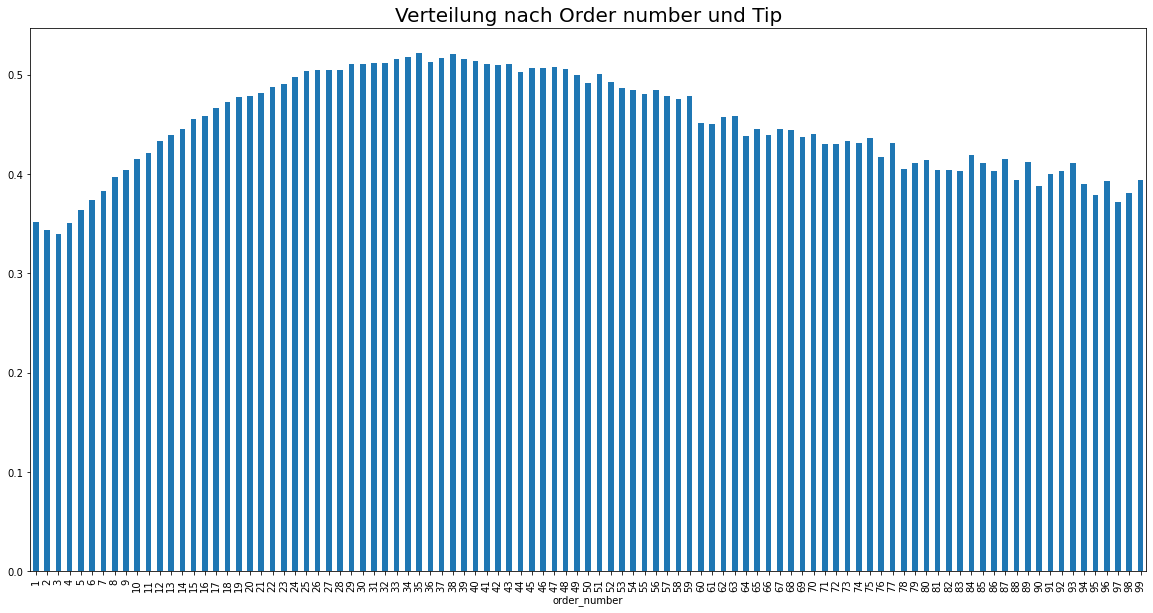

In [46]:
plt.figure(figsize=(20, 10))
ax = instacart_train.groupby('order_number').tip.mean().plot(kind='bar')
ax.set_title(label = 'Verteilung nach Order number und Tip', fontsize = 20)
plt.show()

### Amount of ordered products zu tip

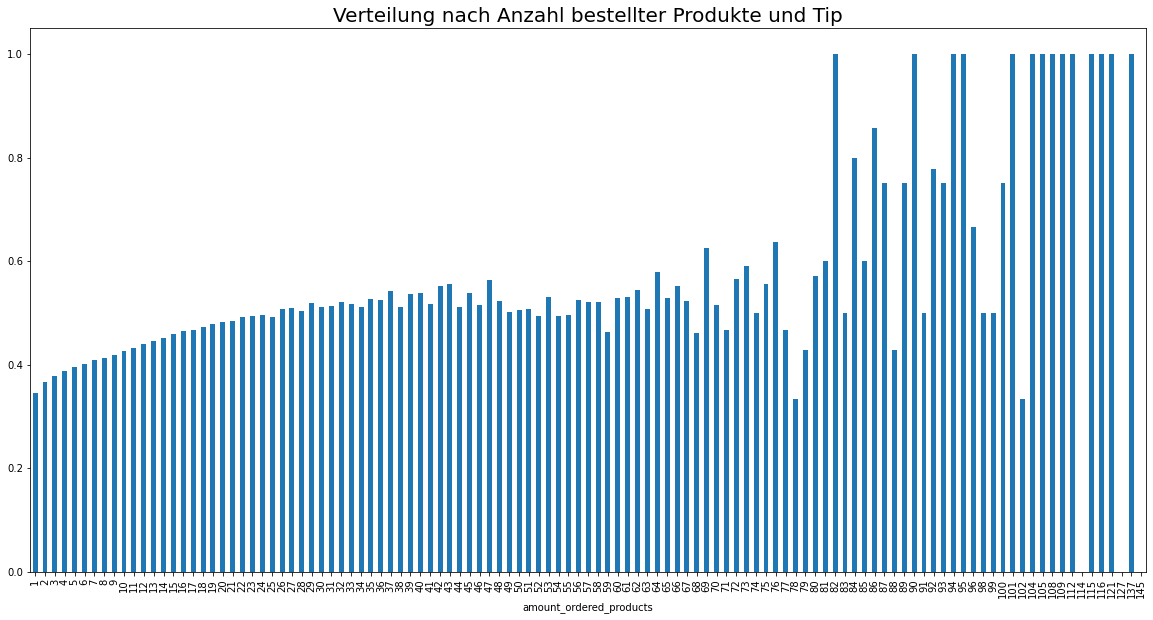

In [47]:
plt.figure(figsize=(20, 10))
ax = instacart_train.groupby('amount_ordered_products').tip.mean().plot(kind='bar')
ax.set_title(label = 'Verteilung nach Anzahl bestellter Produkte und Tip', fontsize = 20)
plt.show()

### Amount of reordered products zu tip

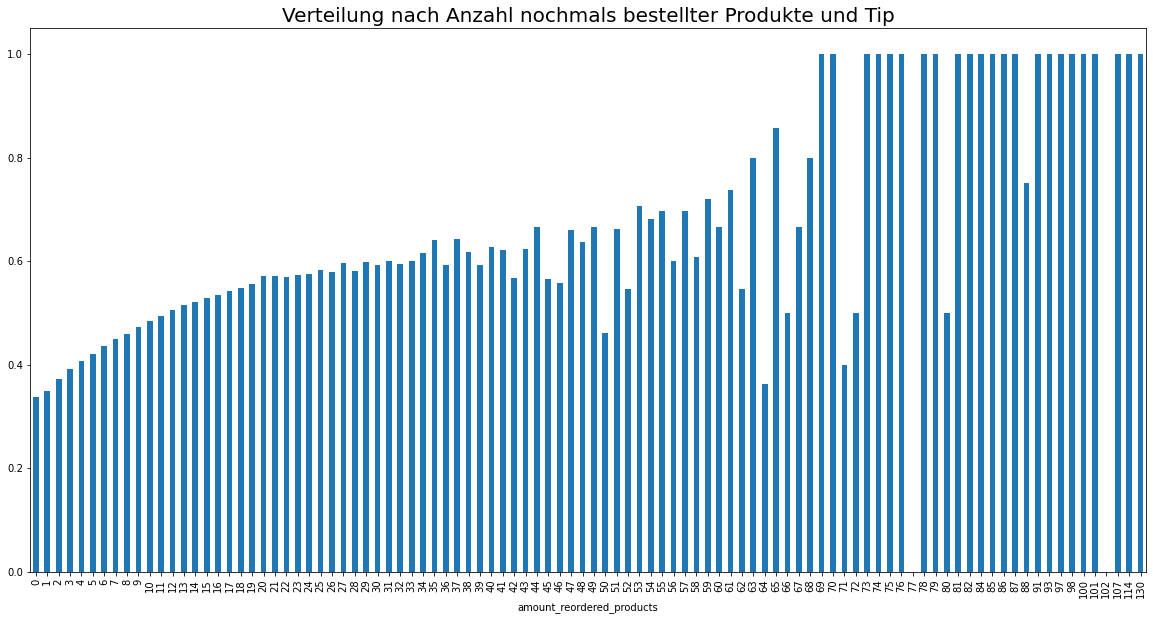

In [48]:
plt.figure(figsize=(20, 10))
ax = instacart_train.groupby('amount_reordered_products').tip.mean().plot(kind='bar')
ax.set_title(label = 'Verteilung nach Anzahl nochmals bestellter Produkte und Tip', fontsize = 20)
plt.show()

### Factor of reordered products zu tip

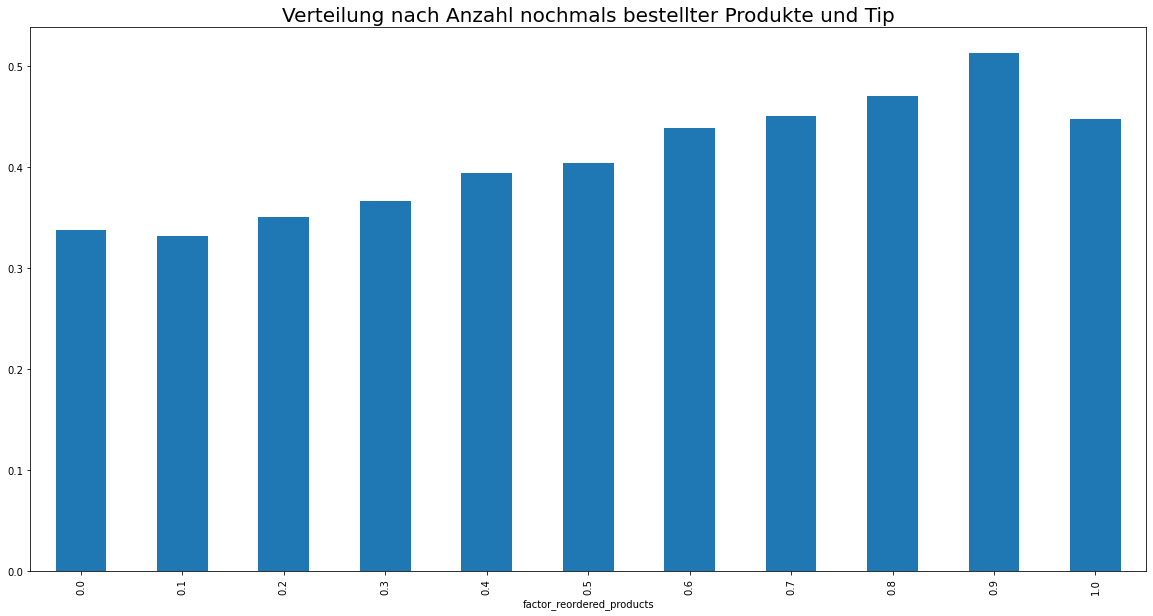

In [49]:
plt.figure(figsize=(20, 10))
ax = instacart_train.groupby('factor_reordered_products').tip.mean().plot(kind='bar')
ax.set_title(label = 'Verteilung nach Anzahl nochmals bestellter Produkte und Tip', fontsize = 20)
plt.show()

## Korrelationen

In [50]:
instacart_train = instacart_train.loc[:,~instacart_train.columns.str.contains('aisles')]
instacart_train = instacart_train.loc[:,~instacart_train.columns.str.contains('departments')]

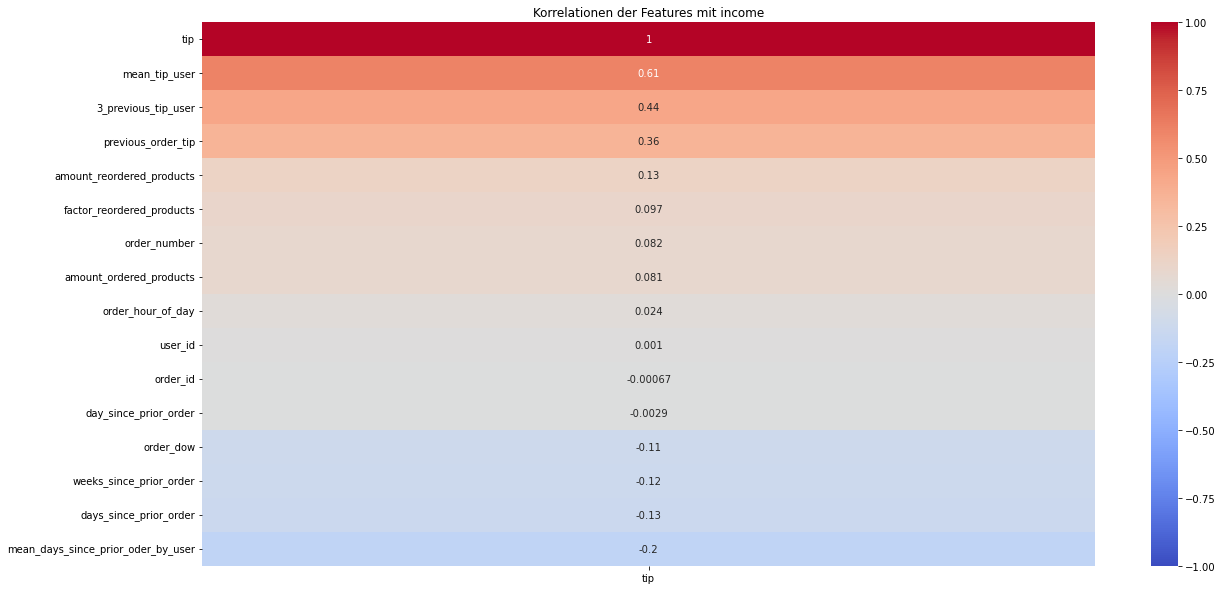

In [51]:
plt.figure(figsize=(20, 10))
corr_with_income = instacart_train.corr()[['tip']].sort_values(by='tip', ascending=False)
heatmap = sns.heatmap(corr_with_income, vmin=-1, vmax=1, annot=True, cmap='coolwarm')
heatmap.set_title('Korrelationen der Features mit income')
plt.show()

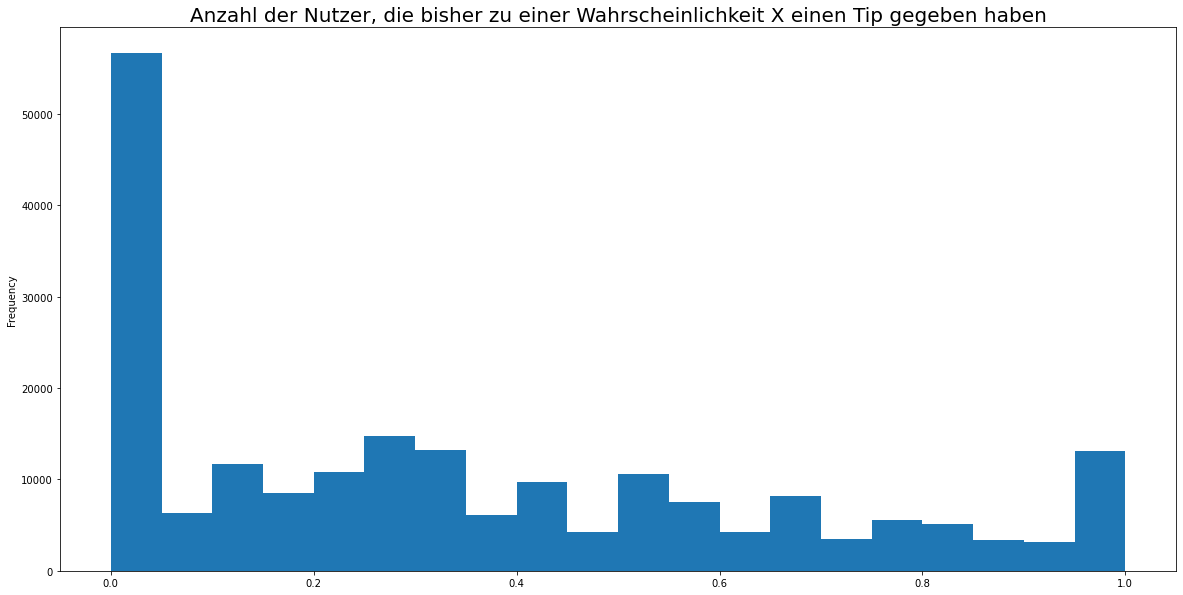

In [52]:
plt.figure(figsize=(20, 10))
ax = instacart_train.groupby('user_id').tip.mean().plot.hist(bins=20)
ax.set_title(label = 'Anzahl der Nutzer, die bisher zu einer Wahrscheinlichkeit X einen Tip gegeben haben', fontsize = 20)
plt.show()

## Datenqualität analysieren

### Outliers
- ToDo: Outlier auswerten und behandeln

### Missing Values
- ToDo: Missing values auswerten und behandeln

In [53]:
instacart_train.isna().sum()

order_id                                   0
tip                                        0
user_id                                    0
eval_set                                   0
order_number                               0
order_dow                                  0
order_hour_of_day                          0
days_since_prior_order                206209
amount_ordered_products                    0
amount_reordered_products                  0
factor_reordered_products                  0
previous_order_tip                         0
3_previous_tip_user                        0
mean_tip_user                              0
weeks_since_prior_order               206209
day_since_prior_order                 206209
mean_days_since_prior_oder_by_user         0
dtype: int64

In [54]:
instacart_train['days_since_prior_order']= instacart_train['days_since_prior_order'].fillna(instacart_train['days_since_prior_order'].mean())

In [55]:
instacart_train.isna().sum()

order_id                                   0
tip                                        0
user_id                                    0
eval_set                                   0
order_number                               0
order_dow                                  0
order_hour_of_day                          0
days_since_prior_order                206209
amount_ordered_products                    0
amount_reordered_products                  0
factor_reordered_products                  0
previous_order_tip                         0
3_previous_tip_user                        0
mean_tip_user                              0
weeks_since_prior_order               206209
day_since_prior_order                 206209
mean_days_since_prior_oder_by_user         0
dtype: int64

# Data Preparation

- Feature Engineering
    - Trinkgeld bei der letzten Bestellung
    - Durchschnitt für User
    - // Anzahl der Produkte pro Bestellung

- Feature Selection
    - chi2
    - f-Value
    - eval_set: Löschen, da kein Zusammenhang mit Zielvariable

- Encoding

## Feature Engineering

### Discretization

- ToDo: Discretize order_dow in weekend and weekday

- ToDo: Discretize days_since_prior_oder

In [57]:
dow_day_dict = {0: 1, 1: 1, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0}

instacart_train['order_dow_discretized'] = instacart_train['order_dow'].map(dow_day_dict, na_action='ignore')

In [58]:
instacart_train.head()

,order_id,tip,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,amount_ordered_products,amount_reordered_products,factor_reordered_products,previous_order_tip,3_previous_tip_user,mean_tip_user,weeks_since_prior_order,day_since_prior_order,mean_days_since_prior_oder_by_user,order_dow_discretized
0,2539329,1,1,prior,1,2,8,NaN,5,0,0.0,0.0,0.000000,1.0,NaN,NaN,20.0,0
1,2398795,1,1,prior,2,3,7,15.0,6,3,0.5,1.0,0.333333,1.0,2.0,1.0,20.0,0
2,473747,1,1,prior,3,3,12,21.0,5,3,0.6,1.0,0.666667,1.0,3.0,0.0,20.0,0
3,2254736,1,1,prior,4,4,7,29.0,5,5,1.0,1.0,1.000000,1.0,4.0,1.0,20.0,0
4,431534,1,1,prior,5,4,15,28.0,8,5,0.6,1.0,1.000000,1.0,4.0,0.0,20.0,0


In [59]:
h = opp[['order_id','add_to_cart_order']]
h.head(15)

,order_id,add_to_cart_order
0,2,1
1,2,2
2,2,3
3,2,4
4,2,5
5,2,6
6,2,7
7,2,8
8,2,9
9,3,1


In [60]:
count_items = h.groupby(['order_id']).max()
count_items.head(10)

,add_to_cart_order
order_id,
2,9
3,8
4,13
5,26
6,3
7,2
8,1
9,15
10,15


In [61]:
count_items.rename(columns = {'add_to_cart_order':'item_count'}, inplace = True)
count_items.head()

,item_count
order_id,
2,9
3,8
4,13
5,26
6,3


In [62]:
#Prüfen, ob richtig gezählt wird
(opp.loc[opp['order_id'] == 3]).count()

order_id                     8
product_id                   8
add_to_cart_order            8
reordered                    8
amount_ordered_products      8
amount_reordered_products    8
departments_id               8
aisles_id                    8
value                        8
dtype: int64

In [63]:
instacart_train_feature_count = pd.merge(instacart_train,
                 count_items[['item_count']],
                 on='order_id')
instacart_train_feature_count.head() 

,order_id,tip,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,amount_ordered_products,amount_reordered_products,factor_reordered_products,previous_order_tip,3_previous_tip_user,mean_tip_user,weeks_since_prior_order,day_since_prior_order,mean_days_since_prior_oder_by_user,order_dow_discretized,item_count
0,2539329,1,1,prior,1,2,8,NaN,5,0,0.0,0.0,0.000000,1.0,NaN,NaN,20.0,0,5
1,2398795,1,1,prior,2,3,7,15.0,6,3,0.5,1.0,0.333333,1.0,2.0,1.0,20.0,0,6
2,473747,1,1,prior,3,3,12,21.0,5,3,0.6,1.0,0.666667,1.0,3.0,0.0,20.0,0,5
3,2254736,1,1,prior,4,4,7,29.0,5,5,1.0,1.0,1.000000,1.0,4.0,1.0,20.0,0,5
4,431534,1,1,prior,5,4,15,28.0,8,5,0.6,1.0,1.000000,1.0,4.0,0.0,20.0,0,8


Create Feature: previous_order_tip mit der Information, ob der Nutzer in der vorhergehenden Bestellungen einen Tip vergeben hat.

In [64]:
orders_tip = instacart_train[instacart_train.tip == 1]
orders_tip.head()

,order_id,tip,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,amount_ordered_products,amount_reordered_products,factor_reordered_products,previous_order_tip,3_previous_tip_user,mean_tip_user,weeks_since_prior_order,day_since_prior_order,mean_days_since_prior_oder_by_user,order_dow_discretized
0,2539329,1,1,prior,1,2,8,NaN,5,0,0.0,0.0,0.000000,1.0,NaN,NaN,20.0,0
1,2398795,1,1,prior,2,3,7,15.0,6,3,0.5,1.0,0.333333,1.0,2.0,1.0,20.0,0
2,473747,1,1,prior,3,3,12,21.0,5,3,0.6,1.0,0.666667,1.0,3.0,0.0,20.0,0
3,2254736,1,1,prior,4,4,7,29.0,5,5,1.0,1.0,1.000000,1.0,4.0,1.0,20.0,0
4,431534,1,1,prior,5,4,15,28.0,8,5,0.6,1.0,1.000000,1.0,4.0,0.0,20.0,0


In [65]:
instacart_train_feature_previous = instacart_train.copy()

In [66]:
instacart_train_feature_previous['orders_with_tip'] = 0
instacart_train_feature_previous.head()

,order_id,tip,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,amount_ordered_products,amount_reordered_products,factor_reordered_products,previous_order_tip,3_previous_tip_user,mean_tip_user,weeks_since_prior_order,day_since_prior_order,mean_days_since_prior_oder_by_user,order_dow_discretized,orders_with_tip
0,2539329,1,1,prior,1,2,8,NaN,5,0,0.0,0.0,0.000000,1.0,NaN,NaN,20.0,0,0
1,2398795,1,1,prior,2,3,7,15.0,6,3,0.5,1.0,0.333333,1.0,2.0,1.0,20.0,0,0
2,473747,1,1,prior,3,3,12,21.0,5,3,0.6,1.0,0.666667,1.0,3.0,0.0,20.0,0,0
3,2254736,1,1,prior,4,4,7,29.0,5,5,1.0,1.0,1.000000,1.0,4.0,1.0,20.0,0,0
4,431534,1,1,prior,5,4,15,28.0,8,5,0.6,1.0,1.000000,1.0,4.0,0.0,20.0,0,0


In [67]:
instacart_train_feature_previous.loc[instacart_train_feature_previous['order_id'].isin(orders_tip),'order_id'] = 1
instacart_train_feature_previous.head()


c:\Users\jdhau\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,order_id,tip,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,amount_ordered_products,amount_reordered_products,factor_reordered_products,previous_order_tip,3_previous_tip_user,mean_tip_user,weeks_since_prior_order,day_since_prior_order,mean_days_since_prior_oder_by_user,order_dow_discretized,orders_with_tip
0,2539329,1,1,prior,1,2,8,NaN,5,0,0.0,0.0,0.000000,1.0,NaN,NaN,20.0,0,0
1,2398795,1,1,prior,2,3,7,15.0,6,3,0.5,1.0,0.333333,1.0,2.0,1.0,20.0,0,0
2,473747,1,1,prior,3,3,12,21.0,5,3,0.6,1.0,0.666667,1.0,3.0,0.0,20.0,0,0
3,2254736,1,1,prior,4,4,7,29.0,5,5,1.0,1.0,1.000000,1.0,4.0,1.0,20.0,0,0
4,431534,1,1,prior,5,4,15,28.0,8,5,0.6,1.0,1.000000,1.0,4.0,0.0,20.0,0,0


In [68]:
#Prüfen, ob es passt
instacart_train_feature_previous.groupby('tip').count()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,amount_ordered_products,amount_reordered_products,factor_reordered_products,previous_order_tip,3_previous_tip_user,mean_tip_user,weeks_since_prior_order,day_since_prior_order,mean_days_since_prior_oder_by_user,order_dow_discretized,orders_with_tip
tip,,,,,,,,,,,,,,,,,,
0,1858960,1858960,1858960,1858960,1858960,1858960,1725357,1858960,1858960,1858960,1858960,1858960,1858960,1725357,1725357,1858960,1858960,1858960
1,1355914,1355914,1355914,1355914,1355914,1355914,1283308,1355914,1355914,1355914,1355914,1355914,1355914,1283308,1283308,1355914,1355914,1355914


In [69]:
#mean tip user

### Discretization

- ToDo: Discretize order_dow in weekend and weekday

- ToDo: Discretize days_since_prior_oder

### Feature Creation

Create Feature: previous_order_tip mit der Information, ob der Nutzer in der vorhergehenden Bestellungen einen Tip vergeben hat.

In [70]:
instacart_train

,order_id,tip,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,amount_ordered_products,amount_reordered_products,factor_reordered_products,previous_order_tip,3_previous_tip_user,mean_tip_user,weeks_since_prior_order,day_since_prior_order,mean_days_since_prior_oder_by_user,order_dow_discretized
0,2539329,1,1,prior,1,2,8,NaN,5,0,0.0,0.0,0.000000,1.0,NaN,NaN,20.0,0
1,2398795,1,1,prior,2,3,7,15.0,6,3,0.5,1.0,0.333333,1.0,2.0,1.0,20.0,0
2,473747,1,1,prior,3,3,12,21.0,5,3,0.6,1.0,0.666667,1.0,3.0,0.0,20.0,0
3,2254736,1,1,prior,4,4,7,29.0,5,5,1.0,1.0,1.000000,1.0,4.0,1.0,20.0,0
4,431534,1,1,prior,5,4,15,28.0,8,5,0.6,1.0,1.000000,1.0,4.0,0.0,20.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3214869,2558525,0,206209,prior,9,4,15,22.0,3,3,1.0,0.0,0.000000,0.4,3.0,1.0,18.0,0
3214870,2266710,0,206209,prior,10,5,18,29.0,9,3,0.3,0.0,0.000000,0.4,4.0,1.0,18.0,0
3214871,1854736,0,206209,prior,11,4,10,30.0,8,6,0.8,0.0,0.000000,0.4,4.0,2.0,18.0,0
3214872,626363,1,206209,prior,12,1,12,18.0,20,14,0.7,0.0,0.000000,0.4,2.0,4.0,18.0,1


## Feature Selection
- Delete eval_set, da es keinen logischen Zusammenhang gibt.
- Delete order_id, da es eine unique ID ist (führt zu Overfitting)
- Delete user_id, da es eine unique ID ist (führt zu Overfitting)

In [71]:
instacart_train.isnull().sum()

order_id                                   0
tip                                        0
user_id                                    0
eval_set                                   0
order_number                               0
order_dow                                  0
order_hour_of_day                          0
days_since_prior_order                206209
amount_ordered_products                    0
amount_reordered_products                  0
factor_reordered_products                  0
previous_order_tip                         0
3_previous_tip_user                        0
mean_tip_user                              0
weeks_since_prior_order               206209
day_since_prior_order                 206209
mean_days_since_prior_oder_by_user         0
order_dow_discretized                      0
dtype: int64

In [72]:
instacart_train = instacart_train.dropna()

In [73]:
instacart_train = instacart_train.drop(columns=['eval_set', 'order_id', 'user_id'])

# Modeling

- ToDo: Train-Test-Split (80/20)
- ToDo: Train baseline models by CV-Cross-Validation

In [74]:
instacart_train = instacart_train.sample(1000000)

X = instacart_train.drop(columns=['tip'])
y = instacart_train['tip']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [75]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)

In [76]:
clf = DummyClassifier(strategy="most_frequent")
dummy_base_scores = cross_val_score(clf, X_train, y_train, cv=5)
print(dummy_base_scores)
print("%0.2f accuracy with a standard deviation of %0.2f" % (dummy_base_scores.mean(), dummy_base_scores.std()))

[0.572875   0.572875   0.572875   0.57288125 0.57288125]
0.57 accuracy with a standard deviation of 0.00


In [77]:
clf = KNeighborsClassifier()
knn_base_scores = cross_val_score(clf, X_train, y_train, cv=5)
print(knn_base_scores)
print("%0.2f accuracy with a standard deviation of %0.2f" % (knn_base_scores.mean(), knn_base_scores.std()))

[0.632675   0.6357625  0.6353375  0.63448125 0.635075  ]
0.63 accuracy with a standard deviation of 0.00


In [78]:
clf = DecisionTreeClassifier()
dt_base_scores = cross_val_score(clf, X_train, y_train, cv=5)
print(dt_base_scores)
print("%0.2f accuracy with a standard deviation of %0.2f" % (dt_base_scores.mean(), dt_base_scores.std()))

[0.69794375 0.6987     0.69618125 0.6974375  0.69741875]
0.70 accuracy with a standard deviation of 0.00


In [86]:
clf = RandomForestClassifier(n=5)
rf_base_scores = cross_val_score(clf, X_train, y_train, cv=5)
print(rf_base_scores)
print("%0.2f accuracy with a standard deviation of %0.2f" % (rf_base_scores.mean(), rf_base_scores.std()))

[0.76966875 0.7700625  0.76948125 0.76918125 0.766875  ]
0.77 accuracy with a standard deviation of 0.00


In [80]:
clf = xgb.XGBClassifier()
xgb_base_scores = cross_val_score(clf, X_train, y_train, cv=5)
print(xgb_base_scores)
print("%0.2f accuracy with a standard deviation of %0.2f" % (xgb_base_scores.mean(), xgb_base_scores.std()))

[0.7790875  0.7790875  0.77881875 0.7786625  0.77718125]
0.78 accuracy with a standard deviation of 0.00


In [81]:
clf = Perceptron()
perceptron_base_scores = cross_val_score(clf, X_train, y_train, cv=5)
print(perceptron_base_scores)
print("%0.2f accuracy with a standard deviation of %0.2f" % (perceptron_base_scores.mean(), perceptron_base_scores.std()))

[0.5611125  0.6546125  0.61014375 0.7303625  0.6483125 ]
0.64 accuracy with a standard deviation of 0.06


In [82]:
clf = MLPClassifier(random_state=1, max_iter=20)
mlp_base_scores = cross_val_score(clf, X_train, y_train, cv=5)
print(mlp_base_scores)
print("%0.2f accuracy with a standard deviation of %0.2f" % (mlp_base_scores.mean(), mlp_base_scores.std()))

c:\Users\jdhau\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\jdhau\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\jdhau\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\jdhau\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\jdhau\anaconda3\lib\site-packages\sklearn\neural_network\_multilaye

[0.77753125 0.7773875  0.7773625  0.77708125 0.77556875]
0.78 accuracy with a standard deviation of 0.00


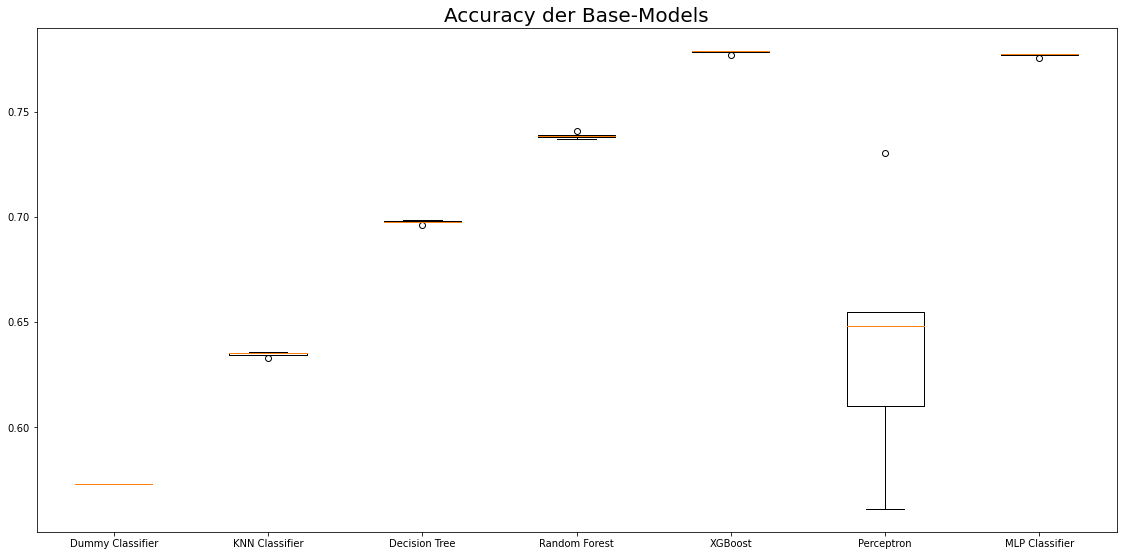

In [83]:
baseline_model = [dummy_base_scores, knn_base_scores, dt_base_scores, rf_base_scores, xgb_base_scores, perceptron_base_scores, mlp_base_scores]

fig = plt.figure(figsize =(15, 7))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
ax.set_title(label = 'Accuracy der Base-Models', fontsize = 20)
 
# Creating plot
bp = ax.boxplot(baseline_model)

# rename ticks 
plt.xticks([1, 2, 3, 4, 5, 6, 7], ['Dummy Classifier', 'KNN Classifier', 'Decision Tree', 'Random Forest', 'XGBoost', 'Perceptron', 'MLP Classifier'])
# show plot
plt.show()

# Hyperparameter Optimierung

Hyperparameter Tuning Gradient Boosting Classifier mit diversen n_estimators, max_depths und learning_rates

In [116]:

params = {
    "n_estimators":[25,100],
    "max_depth":[1,5,9],
    "learning_rate":[0.01,0.1,10]
}
gscv = GridSearchCV(xgb.XGBClassifier(),params,cv=5)
gscv.fit(X_train, y_train)

print(f'Die besten Parameter für den Gradient Boosting Classifier: {gscv.best_params_} \n')

Die besten Parameter für den Gradient Boosting Classifier: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100} 



# Evaluation

## Final model
Basierend auf der Hyperparamter Optimierung wurde das folgende Modell trainiert. 

In [118]:
clf = xgb.XGBClassifier(learning_rate=0.1, max_depth=5, n_estimators=100).fit(X_train, y_train)
y_rf_pred_training = clf.predict(X_train)
y_rf_pred = clf.predict(X_test)

## Confusion Matrix
Die Confusion Matrix zeigt die Performance des Modells basierend auf Actual Values vs. Predicted Values.

<Figure size 1800x1440 with 0 Axes>

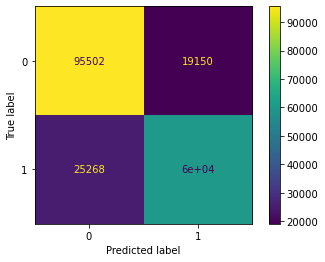

In [119]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
plt.figure(figsize=(25, 20))
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)
plt.show()

## Kennzahlen
Um die Güte des Machine Learning-Modells zu klassifizieren werden die Metriken Accuracy, Precision, Recall und F1-Score verwendet.

### Accuracy on Test and Training Data
Die Accuracy beschreibt die Anzahl der korrekten Vorhersagen im Verhältnis zu der Gesamtzahl der Predictions.

In [120]:
accuracy_rf_clf_on_training_data = accuracy_score(y_train, y_rf_pred_training)
print(f'XGBoost accuracy on training data:  {accuracy_rf_clf_on_training_data}')
accuracy_rf_clf = accuracy_score(y_test, y_rf_pred)
print(f'XGBoost accuracy on test data:  {accuracy_rf_clf}')

XGBoost accuracy on training data:  0.7794225
XGBoost accuracy on test data:  0.77791


### Precision on Test and Training Data
Die Precision beschreibt wie viele der 

In [121]:
precision_rf_clf_on_training_data = precision_score(y_train, y_rf_pred_training)
print(f'XGBoost precision on training data:  {precision_rf_clf_on_training_data}')
precision_rf_clf = precision_score(y_test, y_rf_pred)
print(f'XGBoost precision on test data:  {precision_rf_clf}')

XGBoost precision on training data:  0.7601387944280712
XGBoost precision on test data:  0.7582986242584879


### Recall on Test and Training Data

In [122]:
recall_rf_clf_on_training_data = recall_score(y_train, y_rf_pred_training)
print(f'XGBoost recall on training data:  {recall_rf_clf_on_training_data}')
recall_rf_clf = recall_score(y_test, y_rf_pred)
print(f'XGBoost Forest recall on test data:  {recall_rf_clf}')

XGBoost recall on training data:  0.7065127685851249
XGBoost Forest recall on test data:  0.7039415100529597


### F1-Score on Test and Training Data 

In [123]:
f1_score_rf_clf_on_training_data = f1_score(y_train, y_rf_pred_training)
print(f'XGBoost f1_score on training data:  {f1_score_rf_clf_on_training_data}')
f1_score_rf_clf = f1_score(y_test, y_rf_pred)
print(f'XGBoost f1_score on test data:  {f1_score_rf_clf}')

XGBoost f1_score on training data:  0.7323454018717105
XGBoost f1_score on test data:  0.7301097352015458


<Figure size 1440x720 with 0 Axes>

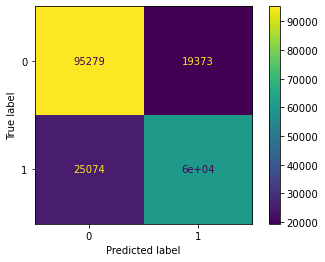

## Confusion Matrix

## Feature Importance

### Feature importance based on Mean Decrease in Impurity

Impurits Decrease importances sind bekannt dafür, dass Sie Features mit hoher Kardinalität bevorzugen. Daher wird neber dem Mean Decrease auch die Permutation Importance betrachtet.

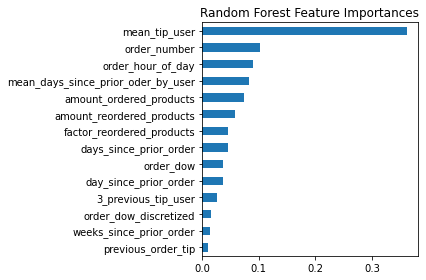

In [84]:
clf = RandomForestClassifier(n_estimators=5)
clf.fit(X_train, y_train)

mdi_importances = pd.Series(
    clf[-1].feature_importances_, index=X.columns
).sort_values(ascending=True)

ax = mdi_importances.plot.barh()
ax.set_title("Random Forest Feature Importances")
ax.figure.tight_layout()

### Feature importance based on Permutation importance

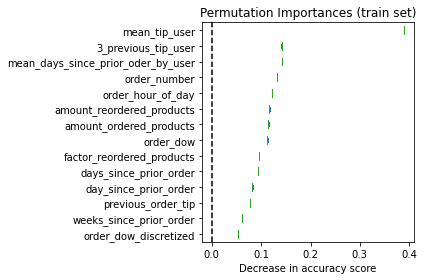

In [85]:
from sklearn.inspection import permutation_importance

clf = RandomForestClassifier(n_estimators=5)
clf.fit(X_train, y_train)

permutation_importances = permutation_importance(clf, X_train, y_train, n_repeats=5, random_state=0)

sorted_importances_idx = permutation_importances.importances_mean.argsort()
importances = pd.DataFrame(
    permutation_importances.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (train set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()